In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from skimage import exposure
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_traffic_sign_data(training_file, validation_file, testing_file, signnames_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    signnames = pd.read_csv(signnames_file)
    
    return train, valid, test, signnames


In [3]:
# preprocessing the data
def preprocess_data(images):
    preprocessed_images = []
    for image in images:
        p2, p98 = np.percentile(image, (2, 98))
        img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
        
        img_eq = exposure.equalize_hist(img_rescale)
        
        preprocessed_images.append(img_eq)
    
    return np.array(preprocessed_images)

In [4]:
train, valid, test, signnames = load_traffic_sign_data('train.p', 'valid.p', 'test.p', 'signname.csv')

In [5]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [6]:
# Let's check the shape of the data
X_train.shape

(34799, 32, 32, 3)

In [7]:
y_train.shape

(34799,)

36

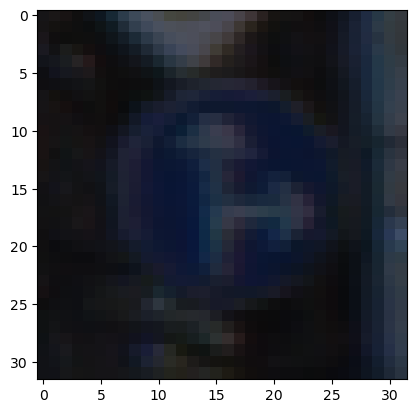

In [8]:
# we will explore the images class and see what the german traffic sign dataset looks like
i = 1001
plt.imshow(X_train[i]) # Showing images are not shuffled
y_train[i]

In [9]:
# Data Preparation is an imporatnat part of project. Data preparation helps us to achieve better accuracy.
# shuffling the dataset

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [10]:
# Transform the data into grayscale and normalize it using onehot encoder

X_train_preprocessed = preprocess_data(X_train)
X_valid_preprocessed = preprocess_data(X_valid)
X_test_preprocessed = preprocess_data(X_test)

y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

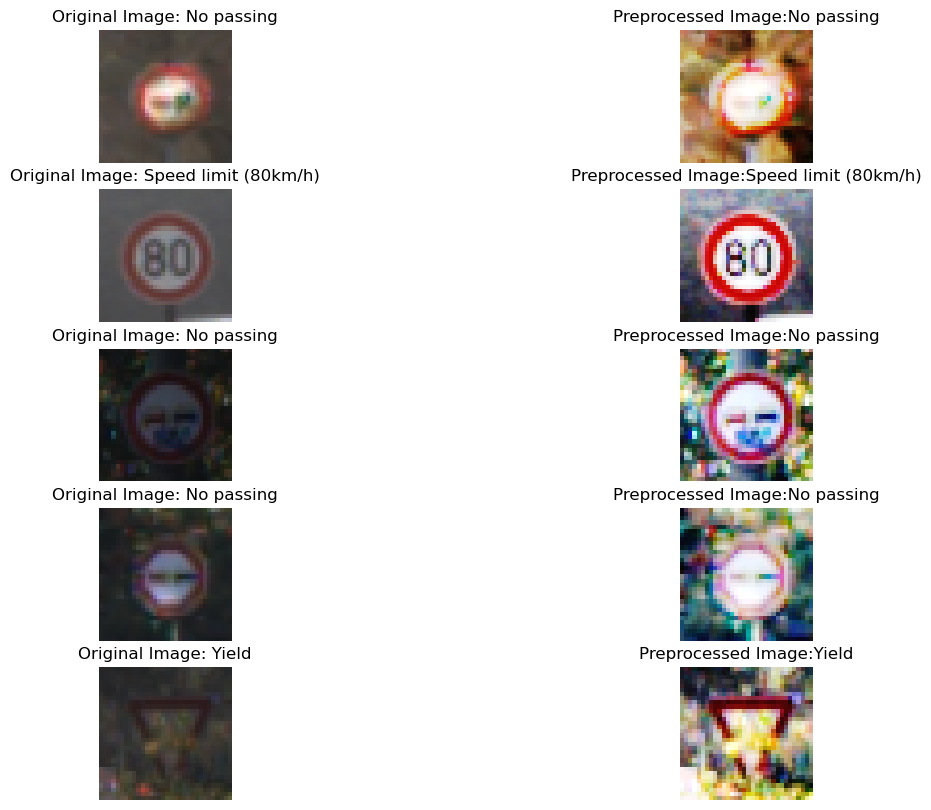

In [11]:
def visualize_data(original_images, preprocessed_images, labels, signnames, n_samples=5):
    fig, axs = plt.subplots(n_samples, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i in range(0, n_samples*2, 2):
        index = np.random.randint(0, len(original_images))
        image = original_images[index]
        axs[i].axis('off')
        axs[i].imshow(image)
        axs[i].set_title('Original Image: ' + signnames.loc[labels[index]].SignName)
        
        axs[i+1].axis('off')
        axs[i+1].imshow(preprocessed_images[index])
        axs[i+1].set_title('Preprocessed Image:' + signnames.loc[labels[index]].SignName)
    plt.show()
visualize_data(X_train, X_train_preprocessed, y_train, signnames)

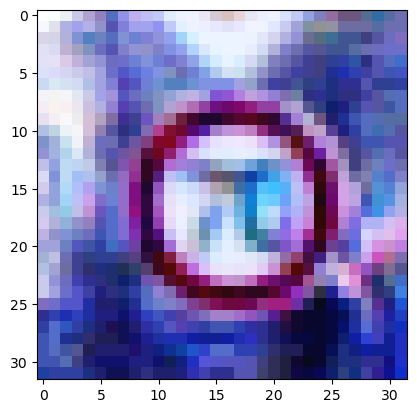

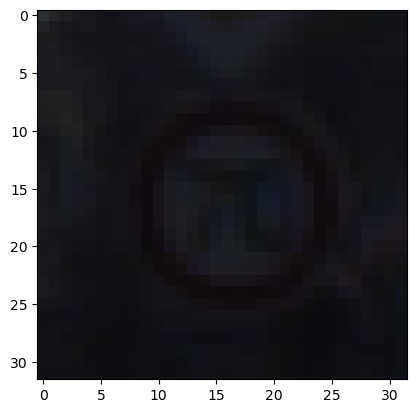

In [12]:
# check the images following the grayscale conversion:
i=514
plt.imshow(X_train_preprocessed[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def create_traffic_sign_recognition_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

input_shape = X_train_preprocessed[0].shape
num_classes = y_train_onehot.shape[1]

model = create_traffic_sign_recognition_model(input_shape, num_classes)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,059 (2.37 MB)

 Trainable params: 622,059 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
image_shape = X_train_preprocessed[i].shape

image_shape

(32, 32, 3)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_traffic_sign_recognition_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(units=num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

input_shape = X_train_preprocessed[0].shape
num_classes = y_train_onehot.shape[1]
model = create_traffic_sign_recognition_model(input_shape, num_classes)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train_preprocessed)

history = model.fit(
    datagen.flow(X_train_preprocessed, y_train_onehot, batch_size=32),
    steps_per_epoch=int(len(X_train_preprocessed) / 32),  # Convert to integer
    epochs=30,
    validation_data=(X_valid_preprocessed, y_valid_onehot),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

best_model = load_model('best_model.keras')

test_loss, test_accuracy = best_model.evaluate(X_test_preprocessed, y_test_onehot, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/30
1084/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2982 - loss: 2.7635
Epoch 1: val_accuracy improved from -inf to 0.75306, saving model to best_model.keras
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.2988 - loss: 2.7611 - val_accuracy: 0.7531 - val_loss: 1.1187
Epoch 2/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5938 - loss: 1.6576
Epoch 2: val_accuracy improved from 0.75306 to 0.75578, saving model to best_model.keras
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.5938 - loss: 1.6576 - val_accuracy: 0.7558 - val_loss: 1.1085
Epoch 3/30
1084/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6648 - loss: 1.3127
Epoch 3: val_accuracy improved from 0.75578 to 0.86349, saving model to best_model.keras
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6649 - loss: 1.3124 - val_accuracy: 0.8635 - val_loss: 0.7705
Epoch 4/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8125 - loss: 0.9486
Epoch 4: val_ac

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Assuming the following variables are defined:
# X_test_preprocessed, y_test_onehot (test dataset), best_model (trained model)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_preprocessed, y_test_onehot, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict classes for test set
y_pred = best_model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate additional evaluation metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Generate classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes))

# Generate confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred_classes))

# Optionally, you can compare the performance of this model with existing approaches and interpret the results.

# For example, if you have results from other models or approaches, you can compare their metrics (accuracy, precision, recall, F1-score) with the metrics of this model.

# You can also visualize the results using plots or tables to provide a clear comparison.

# End of code


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Assuming the following variables are defined:
# X_test_preprocessed, y_test_onehot (test dataset), best_model (trained model)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_preprocessed, y_test_onehot, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict classes for test set
y_pred = best_model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate additional evaluation metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Generate classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes))

# Generate confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred_classes))

# Optionally, you can compare the performance of this model with existing approaches and interpret the results.

# For example, if you have results from other models or approaches, you can compare their metrics (accuracy, precision, recall, F1-score) with the metrics of this model.

# You can also visualize the results using plots or tables to provide a clear comparison.

# End of code


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Assuming the following variables are defined:
# X_test_preprocessed, y_test_onehot (test dataset), best_model (trained model)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_preprocessed, y_test_onehot, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict classes for test set
y_pred = best_model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate additional evaluation metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Generate classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Hypothetical results from a baseline model
baseline_accuracy = 0.85
baseline_precision = 0.82
baseline_recall = 0.88
baseline_f1 = 0.85

# Metrics of the proposed model
proposed_metrics = {
    'Accuracy': test_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}

# Comparison
metrics = list(proposed_metrics.keys())
baseline_metrics = [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1]
proposed_values = list(proposed_metrics.values())

# Plotting
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, baseline_metrics, width, label='Baseline Model')
bars2 = ax.bar(x + width/2, proposed_values, width, label='Proposed Model')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics with Baseline Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_loss, test_accuracy = best_model.evaluate(X_test_preprocessed, y_test_onehot, verbose=1)

y_pred = best_model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(np.argmax(y_test_onehot, axis=1), y_pred_classes)
precision = precision_score(np.argmax(y_test_onehot, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(y_test_onehot, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(y_test_onehot, axis=1), y_pred_classes, average='weighted')

classification_rep = classification_report(np.argmax(y_test_onehot, axis=1), y_pred_classes, target_names=signnames['SignName'])

benchmark_accuracy = 0.85
benchmark_precision = 0.88
benchmark_recall = 0.82
benchmark_f1 = 0.85

accuracy_comparison = accuracy > benchmark_accuracy
precision_comparison = precision > benchmark_precision
recall_comparison = recall > benchmark_recall
f1_comparison = f1 > benchmark_f1

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

print("Classification Report:\n", classification_rep)

import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]
benchmarks = [benchmark_accuracy, benchmark_precision, benchmark_recall, benchmark_f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='b', alpha=0.5, label='Proposed Model Performance')
plt.bar(metrics, benchmarks, color='r', alpha=0.3, label='Benchmark')
plt.title('Comparison with Existing Approaches')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend()
plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf
from skimage import exposure
import pandas as pd
import cv2

# Load the trained model and sign names
model = tf.keras.models.load_model('best_model.keras')
signnames = pd.read_csv('signname.csv')

def preprocess_image(image):
    image = cv2.resize(image, (32, 32))
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Apply histogram equalization to each color channel
    equalized_channels = [exposure.equalize_hist(image[:, :, i]) for i in range(image.shape[-1])]
    # Combine equalized channels into a single RGB image
    image_eq = np.stack(equalized_channels, axis=-1)
    
    return image_eq

def classify_image(image):
    preprocessed_image = preprocess_image(image)
    
    # Expand dimensions to match model input shape
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    
    # Make predictions using the loaded model
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction)
    class_name = signnames.loc[predicted_class].SignName
    
    return predicted_class, class_name

def classify_selected_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        # Read the selected image
        image = cv2.imread(file_path)
        # Classify the image and display the result
        predicted_class, class_name = classify_image(image)
        display_image(image, class_name)

def classify_camera_image():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        
        cv2.imshow('Camera', frame)
        
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        elif key == ord('p'):
            # Classify the camera frame when 'p' is pressed
            predicted_class, class_name = classify_image(frame)
            display_image(frame, class_name)
            break
    
    cap.release()
    cv2.destroyAllWindows()

def display_image(image, class_name):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 300))
    image = Image.fromarray(image)
    photo = ImageTk.PhotoImage(image)
    
    panel.config(image=photo)
    panel.image = photo
    
    result_label.config(text=f'Predicted Class: {class_name}')

# Create the GUI window
window = tk.Tk()
window.title('Traffic Sign Recognition')

# Create buttons for image selection and camera capture
select_image_button = tk.Button(window, text='Select Image', command=classify_selected_image)
select_image_button.pack(pady=5)

camera_button = tk.Button(window, text='Camera', command=classify_camera_image)
camera_button.pack(pady=5)

# Create a label to display the image and prediction result
panel = tk.Label(window)
panel.pack(pady=5)

result_label = tk.Label(window, text='')
result_label.pack(pady=5)

# Start the main event loop
window.mainloop()
